In [26]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from torch.utils.data import Dataset, DataLoader

In [27]:
data = pd.read_csv("data/diamonds.csv")
data.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [28]:
le_cut = LabelEncoder()
le_color = LabelEncoder()
le_clarity = LabelEncoder()

data["cut"] = le_cut.fit_transform(data["cut"])
data["color"] = le_color.fit_transform(data["color"])
data["clarity"] = le_clarity.fit_transform(data["clarity"])

data.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,2,1,3,61.5,55.0,326,3.95,3.98,2.43
1,0.21,3,1,2,59.8,61.0,326,3.89,3.84,2.31
2,0.23,1,1,4,56.9,65.0,327,4.05,4.07,2.31
3,0.29,3,5,5,62.4,58.0,334,4.20,4.23,2.63
4,0.31,1,6,3,63.3,58.0,335,4.34,4.35,2.75


In [29]:
X = data.drop("price", axis=1).values
y = data["price"].values

In [30]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(X_train.shape, X_val.shape, X_test.shape)

X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1)
X_val_tensor = torch.FloatTensor(X_val_scaled)
y_val_tensor = torch.FloatTensor(y_val).unsqueeze(1)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test).unsqueeze(1)

(30206, 9) (7552, 9) (16182, 9)


In [31]:
print(y_train_tensor)

tensor([[ 1582.],
        [ 2964.],
        [ 2994.],
        ...,
        [11279.],
        [ 4362.],
        [  889.]])


In [32]:
class DiamondsDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [33]:
train_dataset = DiamondsDataset(X_train_tensor, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = DiamondsDataset(X_val_tensor, y_val)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataset = DiamondsDataset(X_test_tensor, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [34]:
class DiamondsNet(nn.Module):
    def __init__(self, input_size):
        super(DiamondsNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [35]:
input_size = X_train_scaled.shape[1]
net = DiamondsNet(input_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [36]:
num_epochs = 1000
batch_size = 64
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    net.train()
    for i in range(0, len(X_train_tensor), batch_size):
        batch_X = X_train_tensor[i:i+batch_size]
        batch_y = y_train_tensor[i:i+batch_size]
        
        outputs = net(batch_X)
        loss = criterion(outputs, batch_y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    net.eval()
    with torch.no_grad():
        train_predictions = net(X_train_tensor)
        train_loss = criterion(train_predictions, y_train_tensor)
        train_losses.append(train_loss.item())
        
        val_predictions = net(X_test_tensor)
        val_loss = criterion(val_predictions, y_test_tensor)
        val_losses.append(val_loss.item())
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

Epoch [100/1000], Train Loss: 1293141.1250, Val Loss: 1168287.0000
Epoch [200/1000], Train Loss: 1271332.5000, Val Loss: 1149908.3750
Epoch [300/1000], Train Loss: 1259832.7500, Val Loss: 1138754.6250
Epoch [400/1000], Train Loss: 1245012.5000, Val Loss: 1124992.3750
Epoch [500/1000], Train Loss: 1235792.2500, Val Loss: 1118243.7500
Epoch [600/1000], Train Loss: 1234689.8750, Val Loss: 1117060.3750
Epoch [700/1000], Train Loss: 1230578.2500, Val Loss: 1112768.1250
Epoch [800/1000], Train Loss: 1230131.3750, Val Loss: 1111353.0000
Epoch [900/1000], Train Loss: 1222223.6250, Val Loss: 1105141.5000
Epoch [1000/1000], Train Loss: 1218935.8750, Val Loss: 1103441.3750


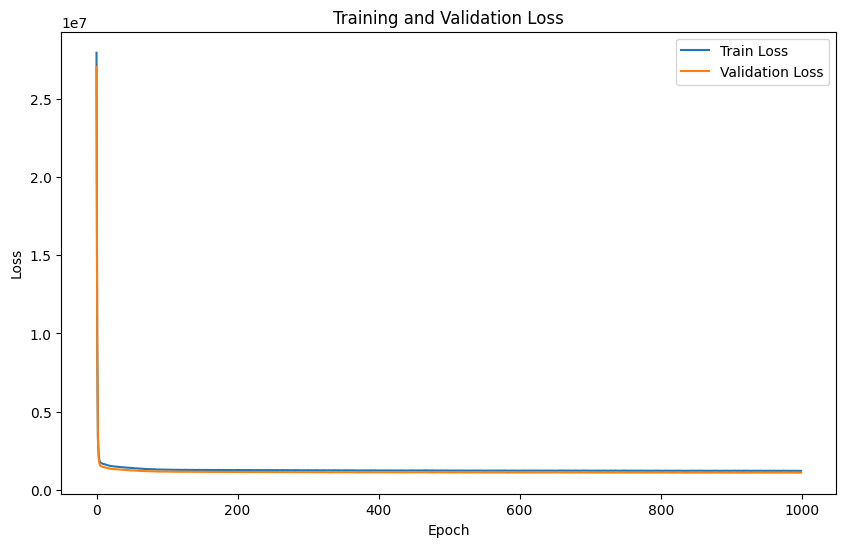

In [37]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
plt.close()

In [38]:
net.eval()
with torch.no_grad():
    y_pred = net(X_test_tensor).numpy().flatten()

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Final Results:')
print(f'\tMean Absolute Error: {mae:.4f}')
print(f'\tMean Squared Error: {mse:.4f}')
print(f'\tr2 Score: {r2:.4f}')

Final Results:
	Mean Absolute Error: 566.8256
	Mean Squared Error: 1103441.3432
	r2 Score: 0.9292
